Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# KGC 2024 MasterClass: Generating and analyzing knowledge graphs using GenAI and Neptune Analytics
# Notebook 1: Populate Knowledge Graph

This notebook loads base organizational data, plus press release documents and Comprehend-extracted entities and events, into a knowledge graph running on Amazon Neptune.

The data you will need is a set of CSV files available in a public S3 bucket. If you are interested to know how this data was prepared, check our notebook 0-PrepSources.ipynb.

Here is our data model:

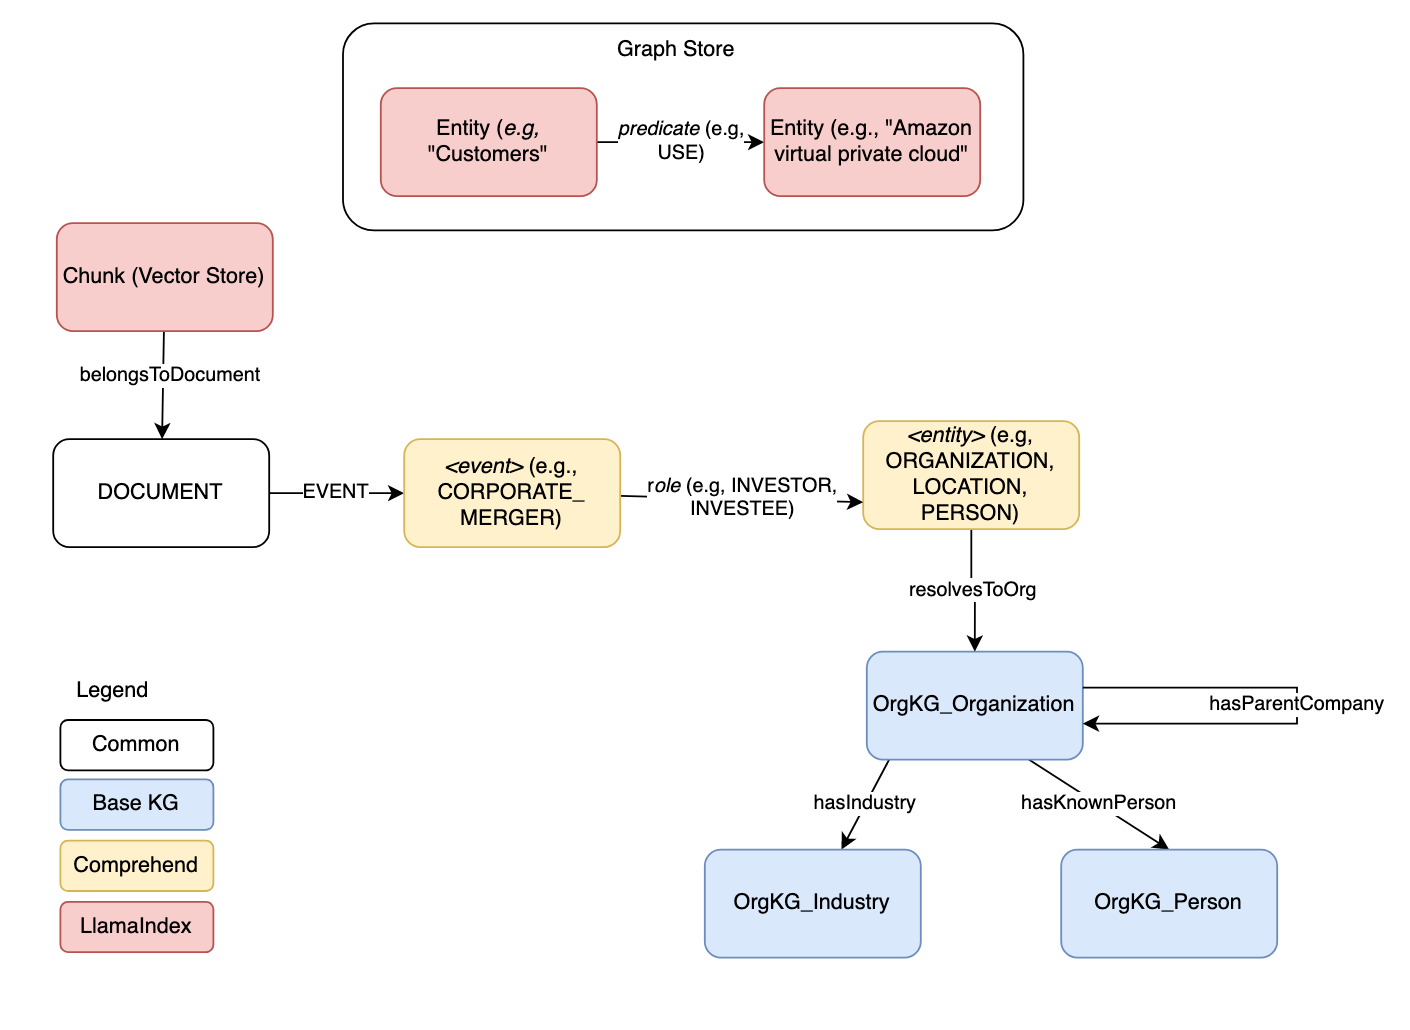

We load into a Neptune Analytics graph three sets of data:

1. Base org data: organizations, persons, and industries (blue boxes).

2. Press release documents and their text content (white boxes).

3. Comprehend extraction of press releases in graph form. We link the extraction results to the base org data (yellow boxes). 

The next figure depicts our design.

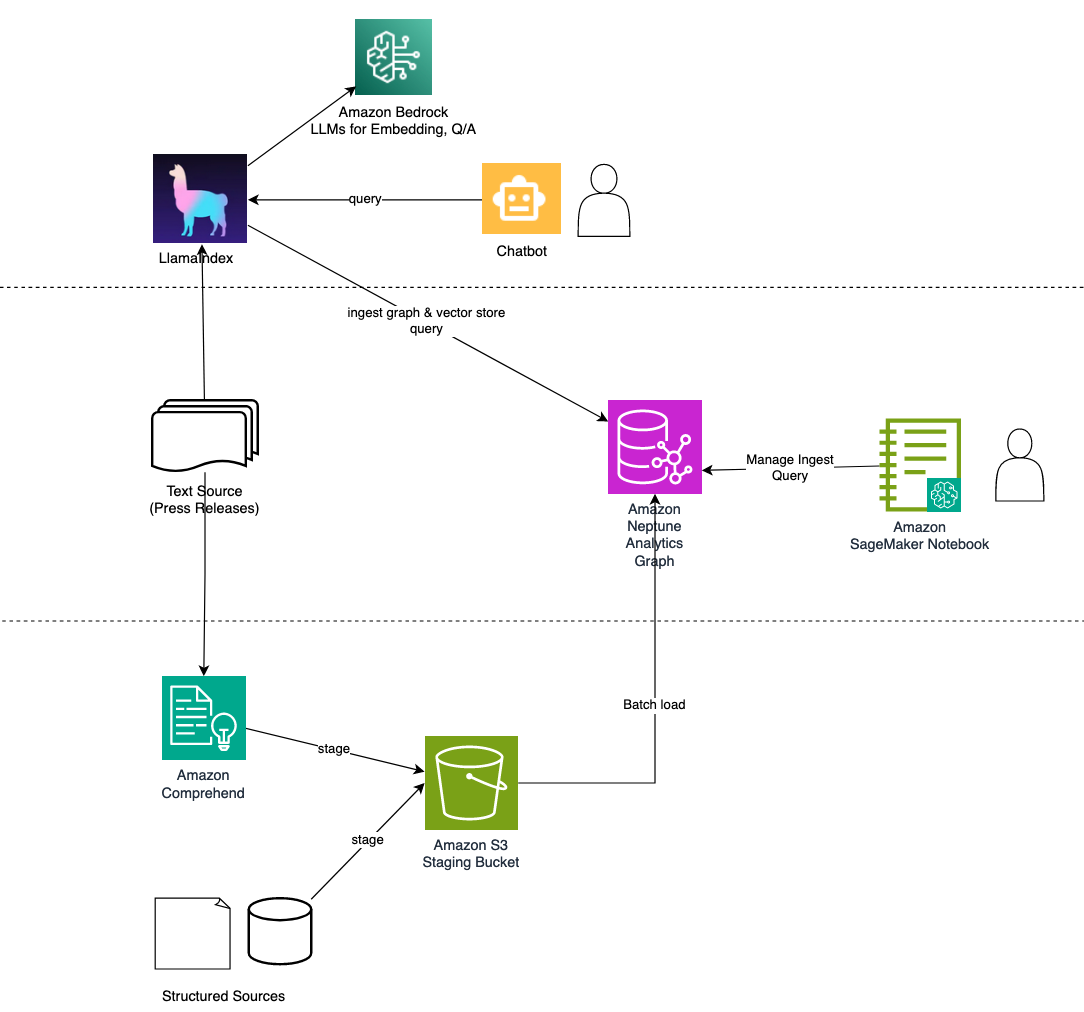

In this notebook we load into Neptune structured data and extracted entities from unstructured data in the bottom third of the figure. 

To run this notebook you need a Neptune Analytics graph that is accessible from this notebook instance. See README.md for detailed setup instructions.


## Batch-load org data to Neptune graph

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

region = config.aws_region
s3_bucket = f"s3://aws-neptune-customer-samples-{region}/kgc2024_na/prepped/"
s3_bucket


In [ ]:
%%oc

CALL neptune.load({
    format: "csv", 
    source: "${s3_bucket}", 
    region : "${region}",
    format: "csv",
    failOnError: False,
    concurrency: 1
})


## View stats - nodes and edges in the graph
Wait a minute if stats shows no change. Try again.

In [ ]:
%summary pg --detailed

## Explore the org data
### Base org KG

In [ ]:
%%oc

MATCH (o:OrgKG_Organization)
OPTIONAL MATCH (o)-[:hasIndustry]->(i)
OPTIONAL MATCH (o)-[:hasParentCompany]->(p)
OPTIONAL MATCH (o)-[:hasKnownPerson]->(r)

WITH id(o) as org_id, o.name as org_name, 
    collect(distinct id(i)) as industries,
    id(p) as parent_co_id, 
    collect(distinct id(r)) as related_persons
RETURN org_id, org_name, parent_co_id, industries, related_persons
ORDER BY org_id

### Press release documents that mention Amazon

In [ ]:
%%oc

MATCH path=(d:DOCUMENT)-[ev]->(obs)-[role]->(ent)-[res:resolvesToOrg]->(org {`~id`: "http://dbpedia.org/resource/Amazon_(company)"})
RETURN path
LIMIT 100

### Documents that mention both Amazon and Whole Foods

In [ ]:
%%oc

MATCH (org:OrgKG_Organization)<-[resolve:resolvesToOrg]-(o:ORGANIZATION)<-[role]-(e)<-[event]-(d:DOCUMENT),
(d:DOCUMENT)-[event2]->(e2)-[role2]->(o2:ORGANIZATION)-[resolve2:resolvesToOrg]->(org2:OrgKG_Organization)

WHERE id(org)="http://dbpedia.org/resource/Amazon_(company)" 
and id(org2)="http://dbpedia.org/resource/Whole_Foods_Market"

RETURN d.title as title, 
    o.primaryName as org1_name, 
    type(role) as role_type, 
    labels(e) as event,
    o2.primaryName as org2_name,
    type(role2) as role_type_2,
    labels(e2) as event2
LIMIT 100

### Names for Amazon from press releases

In [ ]:
%%oc

MATCH (o:OrgKG_Organization {`~id`: "http://dbpedia.org/resource/Amazon_(company)"})<-[:resolvesToOrg]-(co)
RETURN co.primaryName as name